## import

In [1]:
import pandas as pd
import numpy as np
import warnings
import sys
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

try: 
    import holidays
except:
    !pip install holidays
    import holidays
    
try:
    from prophet import Prophet
except: 
    !pip install Prophet
    from prophet import Prophet
    
try:
    from pmdarima.arima import auto_arima
except:
    !pip install pmdarima
    from pmdarima.arima import auto_arima

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

%matplotlib inline

%precision 4   


warnings.filterwarnings("ignore")



Assignment 3

Time series forecast competition! 


This is a time series forecast assignment. The file ’data.csv’ has hourly data for two variables (v1 & v2) from  2022-01-01 00:00 to 2024-10-31 23:00. v1 and v2 are certain KPIs measured on the same service point. 

Your task is to give hourly predictions for v1 and v2 from 2024-11-01 00:00 to 2024-11-30 23:00. You can use any tools and methods to predict the values. v1 and v2 values are somehow related, which may, or may not, help you in your predictions. Create at least three different models and select one for the final forecast.

Predictions are going to be compared to the actual measurements of v1 & v2 for this period, which are not shared. Goodness-of-fit will be measured by the combined R2s of those two time series (R2 for v1 + R2 for v2) and will be published on an anonymous basis upon grading the assignments. Each student will get an individual feedback about his/her goodness-of-fit so you can directly compare your result to the rest of the class. 

What you need to turn in:
1. A Jupyter notebook of your forecasting exercise. 
Carry out EDA and try at least three different methods for the forecast. 
Build your models on a step-by-step basis and make sure you document your workflow. 
Create informative graphs and visualizations and keep your code clean. Don’t litter your notebook output with the display of interim results. 
2. A csv file called ‘forecast_firstname_lastname.csv’ where firstname and lastname are your first and last names. The template with the appropriate timestamps are provided, please fill up this file and rename it accordingly. 


Grading
The traditional part (max 24 points)
Project design, introduction: 2 points
EDA and feature engineering: 6 points
Model building, model selection: 10 points
Write-up, overall notebook design and coding quality: 6 points.

The competitive part (max 6 points)
Students will be ordered on the basis of the goodness of fit of their forecasts (based on R2 on v1 and R2 on v2)

The best 2 students get 6 points
Students 3-4 get 5 points
Students 5-7 get 4 points
Students 8-11 get 3 points
Students 12-15 get 2 points
Students 16-18 get 1 point
Students 19-20 get 0 points

## helper functions and imports 

In [2]:

def rolling_window_split_proportions(n_samples, train_frac, test_frac, n_folds):
    """
    Generates train/test indices for a rolling window cross-validation 
    based on proportions of the total number of samples.
    
    Parameters:
      n_samples : Total number of samples.
      train_frac: Fraction of n_samples to use for training.
      test_frac : Fraction of n_samples to use for testing.
      n_folds   : Desired number of folds.
      
    Returns:
      A list of (train_indices, test_indices) tuples.
    """
    # Compute window sizes based on proportions.
    train_window = int(n_samples * train_frac)
    test_window = int(n_samples * test_frac)
    
    # Compute step so that we get exactly n_folds splits.
    # The maximum starting index for a fold is: n_samples - (train_window + test_window).
    # We then divide that span evenly among (n_folds - 1) steps.
    if n_folds > 1:
        step = (n_samples - (train_window + test_window)) // (n_folds - 1)
    else:
        step = 0  # if only one fold, no step is needed.
    
    splits = []
    for i in range(n_folds):
        start = i * step
        # Make sure indices don't exceed n_samples.
        train_idx = np.arange(start, start + train_window)
        test_idx  = np.arange(start + train_window, start + train_window + test_window)
        # If the test indices go beyond available samples, break out.
        if test_idx[-1] >= n_samples:
            break
        splits.append((train_idx, test_idx))
    return splits

# Example usage:
n_samples = 23152  # size of your work set
train_frac = 0.60  # 60% for training
test_frac  = 0.20  # 20% for testing
n_folds    = 5     # exactly 5 folds

splits = rolling_window_split_proportions(n_samples, train_frac, test_frac, n_folds)
print("Generated Splits:")
for i, (train_idx, test_idx) in enumerate(splits):
    print(f"Fold {i}: Train indices {train_idx[0]} to {train_idx[-1]}, "
          f"Test indices {test_idx[0]} to {test_idx[-1]}")
    


Generated Splits:
Fold 0: Train indices 0 to 13890, Test indices 13891 to 18520
Fold 1: Train indices 1157 to 15047, Test indices 15048 to 19677
Fold 2: Train indices 2314 to 16204, Test indices 16205 to 20834
Fold 3: Train indices 3471 to 17361, Test indices 17362 to 21991
Fold 4: Train indices 4628 to 18518, Test indices 18519 to 23148


In [39]:
def cross_validate_model_rolling_proportions(model, X_exog, y, train_frac, test_frac, n_folds):
    """
    Cross-validates a model using a rolling window approach defined by proportions.
    
    Parameters:
      model     : An object with .fit(X, y) and .predict(X) methods.
      X_exog    : pd.DataFrame of exogenous features.
      y         : Target variable (pd.Series for univariate, pd.DataFrame for multivariate).
      train_frac: Fraction of total samples used for training in each fold.
      test_frac : Fraction of total samples used for testing in each fold.
      n_folds   : Desired number of folds.
      
    Returns:
      results_df  : DataFrame with per-fold RMSE and R².
      avg_metrics : Series with average metrics across folds.
    """
    from sklearn.metrics import mean_squared_error, r2_score
    import pandas as pd
    import numpy as np
    
    n_samples = len(y)
    splits = rolling_window_split_proportions(n_samples, train_frac, test_frac, n_folds)
    fold_results = []
    
    
    for fold, (train_idx, test_idx) in enumerate(splits):
        
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train, X_test = X_exog.iloc[train_idx], X_exog.iloc[test_idx]
        
        # Reset indices so that training and test sets start at 0
        y_train = y_train.reset_index(drop=True)
        y_test  = y_test.reset_index(drop=True)
        X_train = X_train.reset_index(drop=True)
        X_test  = X_test.reset_index(drop=True)
        
        try:
            # Fit the model on the training data
            model.fit(X_train, y_train)
            # Predict on the test data
            preds = model.predict(X_test)
            
            # Calculate RMSE and R²
            if isinstance(y, pd.DataFrame):
                metrics = {}
                for col in y.columns:
                    rmse = np.sqrt(mean_squared_error(y_test[col], preds[col]))
                    r2   = r2_score(y_test[col], preds[col])
                    metrics[f'{col}_rmse'] = rmse
                    metrics[f'{col}_r2'] = r2
                print(f"Fold {fold}: {metrics}")
                fold_results.append(metrics)
            else:
                rmse = np.sqrt(mean_squared_error(y_test, preds))
                r2   = r2_score(y_test, preds)
                print(f"Fold {fold}: RMSE={rmse:.4f}, R²={r2:.4f}")
                fold_results.append({'rmse': rmse, 'r2': r2})
        except Exception as e:
            print(f"Fold {fold} failed: {e}")
    
    results_df = pd.DataFrame(fold_results)
    avg_metrics = results_df.mean()
    print("\nAverage Metrics (Rolling Proportions):")
    print(avg_metrics)
    return results_df, avg_metrics

In [4]:
# Load the data
df = pd.read_csv("data.csv", parse_dates=['ts'], index_col='ts')

## Feature engineering: 

Below are brief explanations for each of the feature engineering techniques:
	•	Sine and Cosine for Hour/Day Cycles:
Time features such as hour-of-day or day-of-week are cyclical. Instead of treating them as linear integers (where 23 and 0 would appear far apart), sine and cosine transformations create a circular representation. This preserves the idea that the end of a cycle (23:00) is immediately followed by the beginning (00:00).
	•	Cyclical Encoding for Days of the Week:
Similar to hours, days of the week also repeat in a cycle. Transforming the day-of-week into sine and cosine components helps the model capture the smooth transition from one day to the next, ensuring that Sunday and Monday are recognized as consecutive days.
	•	Cross Lags:
These features use the past value of one variable to help predict the current value of the other. Since v1 and v2 are interrelated, incorporating a lag of one (e.g., using v2’s previous value to predict v1) allows the model to capture the dynamic interplay between the two KPIs.
	•	Rolling Window Statistics:
Calculating moving averages or standard deviations over a specified window (like 24 hours) provides insights into recent trends and volatility. These features help the model understand local behavior and smooth out short-term fluctuations or noise.
	•	Trend Features:
Adding a linear trend (or even a quadratic trend) helps the model capture long-term changes or growth patterns in your data. This is especially useful if the underlying process has a systematic upward or downward movement over time.

These techniques enrich your model by capturing periodic patterns, interactions between variables, local variations, and long-term trends—all of which can improve forecast accuracy in time series models like ARIMA, VAR, or profit models.

In [5]:
# Generate Time-Based Features
df["year"] = df.index.year
df["quarter"] = df.index.quarter
df["month"] = df.index.month
df["day"] = df.index.day
df['hour'] = df.index.hour
df["dayofweek"] = df.index.dayofweek + 1
df['weekend'] = (df['dayofweek'] >= 5).astype(int)

# Cyclical Time Encoding 
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# Generate school holiday - maybe its relevant
df["school_off"] = (
    ((df["day"] > 15) & (df["month"] == 5) & (df["day"] <= 30))
    | ((df["month"] == 6) | (df["month"] == 7))
    | ((df["day"] < 15) & (df["month"] == 8))
    | ((df["day"] > 20) & (df["month"] == 12)))

# Extract holidays 
df["is_eu_holiday"] = df.index.normalize().isin(
    {d for country in ["FR", "ES", "IT", "AT"] for d in holidays.CountryHoliday(country, years=[2022, 2023, 2024])})

df["is_us_holiday"] = df.index.normalize().isin(
    holidays.US(years=[2022, 2023, 2024]))

# Lagged features 
df['v1_lag1'] = df['v1'].shift(1)
df['v2_lag1'] = df['v2'].shift(1)
# 24 hours lags (to capture daily cycles)
df['v1_lag24'] = df['v1'].shift(24)
df['v2_lag24'] = df['v2'].shift(24)

# Cross lags 
df['v1_from_v2_lag1'] = df['v2'].shift(1)
df['v2_from_v1_lag1'] = df['v1'].shift(1)

# Moving average
df['v1_roll24_mean'] = df['v1'].rolling(window=24).mean()
df['v2_roll24_mean'] = df['v2'].rolling(window=24).mean()
df['v1_roll24_std'] = df['v1'].rolling(window=24).std()
df['v2_roll24_std'] = df['v2'].rolling(window=24).std()

# Trends 
df['trend'] = np.arange(len(df))
df['trend_sq'] = df['trend'] ** 2

## work and holdout splits 
Holdout Period:
You’ve set aside September and October 2024 as your holdout. This is useful for validating your models on the most recent data. One thing to keep in mind is that your final forecasting target is November 2024, which is outside the current data range. So, while the holdout helps assess your models’ performance on recent history, ensure you consider potential changes when forecasting into an unseen period.
	•	Work Set:
Your work set (everything before November 2024) gives you a solid basis for training and model development. It’s important that the work set is representative of the patterns you expect to continue into the forecast period.

In [8]:
df_holdout = df[(df['year'] == 2024) & (df['month'].isin([9,10]))]
df_work = df[(df['year'] < 2024) | ((df['year'] == 2024) & (~df['month'].isin([9,10])))]
print(f"- Work set size: {df_work.shape[0]} rows")
print(f"- Holdout set size: {df_holdout.shape[0]} rows")

- Work set size: 23152 rows
- Holdout set size: 1440 rows


In [9]:
df.head().T

ts,2022-01-01 00:00:00,2022-01-01 01:00:00,2022-01-01 02:00:00,2022-01-01 03:00:00,2022-01-01 04:00:00
v1,0.999036,0.695036,0.764995,0.297017,0.366184
v2,0.318587,0.265836,0.320261,0.064074,0.083961
year,2022,2022,2022,2022,2022
quarter,1,1,1,1,1
month,1,1,1,1,1
day,1,1,1,1,1
hour,0,1,2,3,4
dayofweek,6,6,6,6,6
weekend,1,1,1,1,1
hour_sin,0.0,0.258819,0.5,0.707107,0.866025


## EDA 

Correlation Matrix:
           v1        v2
v1  1.000000  0.911494
v2  0.911494  1.000000


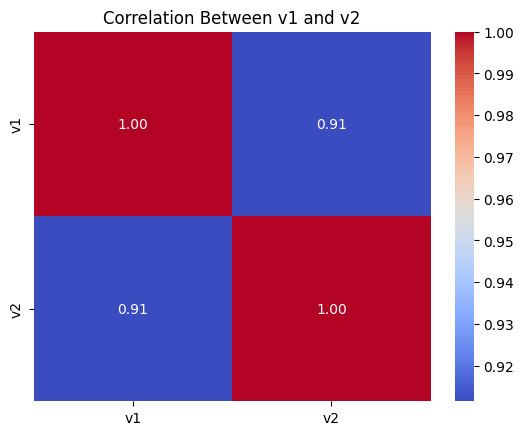

In [10]:
# Calculate correlation
correlation = df[['v1', 'v2']].corr()
print("Correlation Matrix:\n", correlation)

# Visualize correlation
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between v1 and v2")
plt.show()

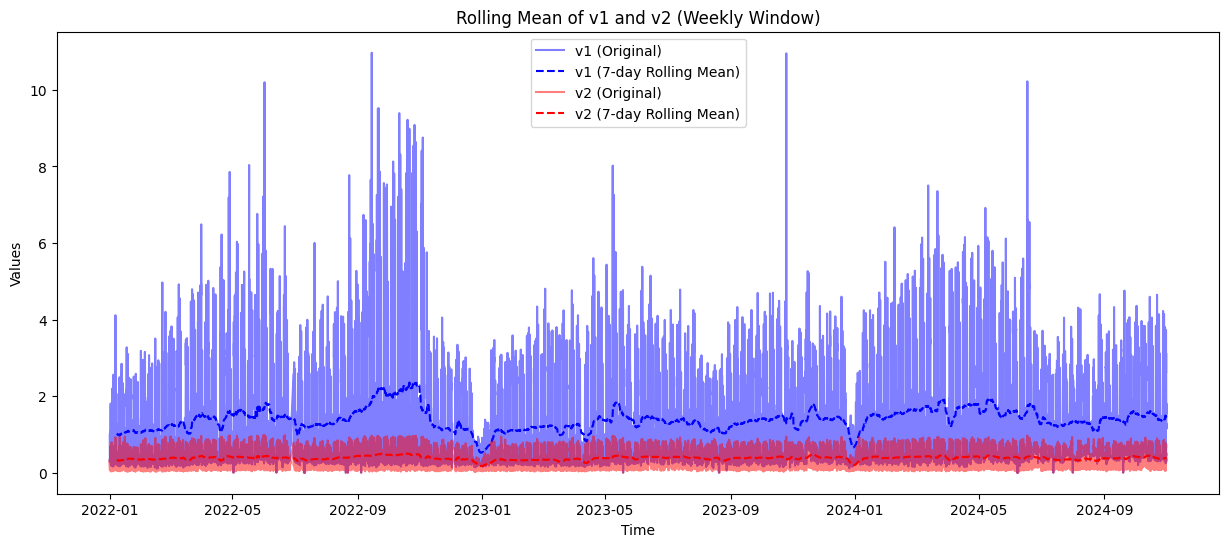

In [11]:

# Rolling mean and standard deviation
window_size = 24 * 7  # Weekly window
df_rolling = df[['v1', 'v2']].rolling(window=window_size).mean()

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['v1'], alpha=0.5, label="v1 (Original)", color="blue")
plt.plot(df_rolling.index, df_rolling['v1'], label="v1 (7-day Rolling Mean)", color="blue", linestyle="dashed")
plt.plot(df.index, df['v2'], alpha=0.5, label="v2 (Original)", color="red")
plt.plot(df_rolling.index, df_rolling['v2'], label="v2 (7-day Rolling Mean)", color="red", linestyle="dashed")
plt.legend()
plt.title("Rolling Mean of v1 and v2 (Weekly Window)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] < 0.05:
        print("✅ The time series is stationary (p < 0.05)")
    else:
        print("❌ The time series is NOT stationary (p >= 0.05)")

print("ADF Test for v1:")
adf_test(df['v1'])

print("\nADF Test for v2:")
adf_test(df['v2'])

ADF Test for v1:
ADF Statistic: -20.69186073853296
p-value: 0.0
Critical Values:
   1%: -3.4306164704426654
   5%: -2.861657771771178
   10%: -2.566832686487071
✅ The time series is stationary (p < 0.05)

ADF Test for v2:
ADF Statistic: -20.598352688554975
p-value: 0.0
Critical Values:
   1%: -3.4306164704426654
   5%: -2.861657771771178
   10%: -2.566832686487071
✅ The time series is stationary (p < 0.05)


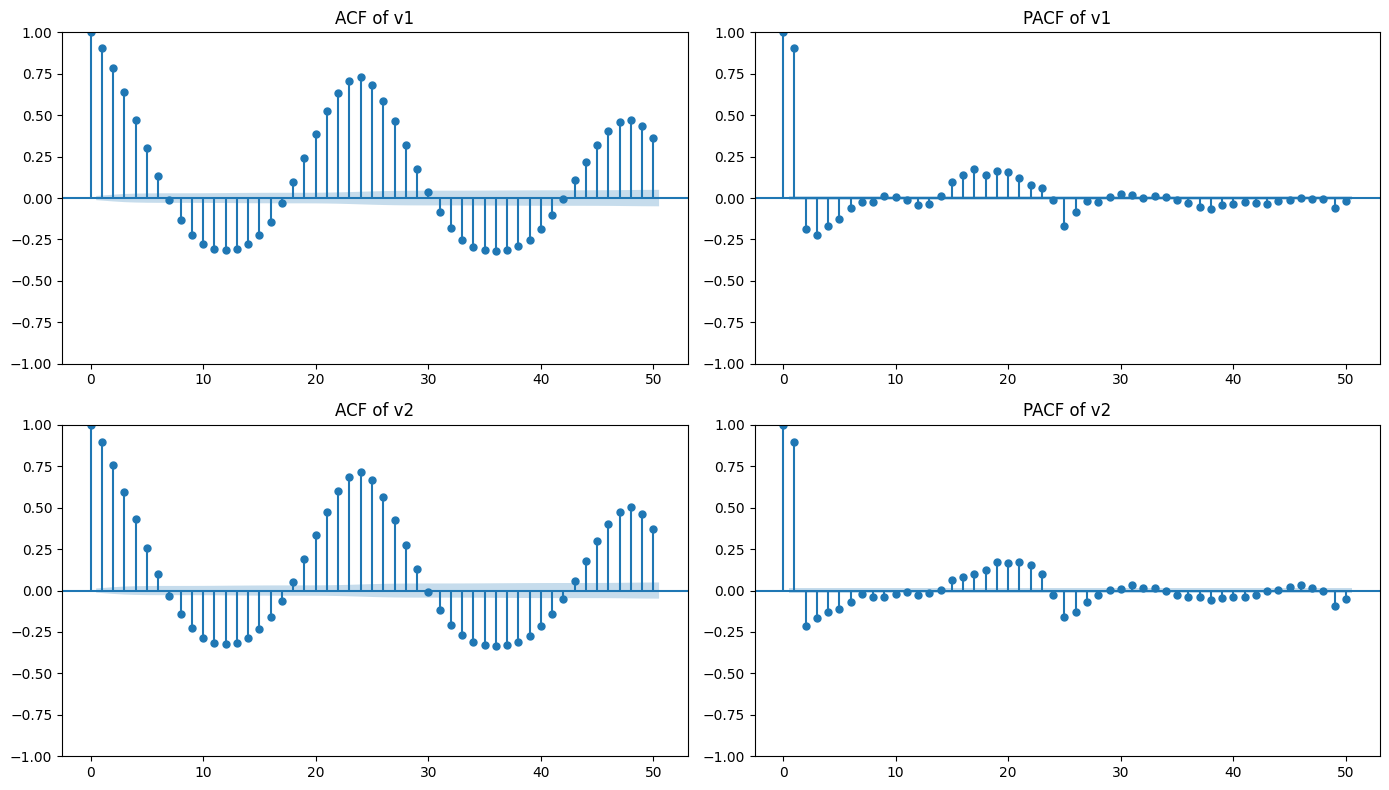

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ACF and PACF for v1
plot_acf(df['v1'].dropna(), ax=axes[0, 0], lags=50)
axes[0, 0].set_title("ACF of v1")
plot_pacf(df['v1'].dropna(), ax=axes[0, 1], lags=50)
axes[0, 1].set_title("PACF of v1")

# ACF and PACF for v2
plot_acf(df['v2'].dropna(), ax=axes[1, 0], lags=50)
axes[1, 0].set_title("ACF of v2")
plot_pacf(df['v2'].dropna(), ax=axes[1, 1], lags=50)
axes[1, 1].set_title("PACF of v2")

plt.tight_layout()
plt.show()

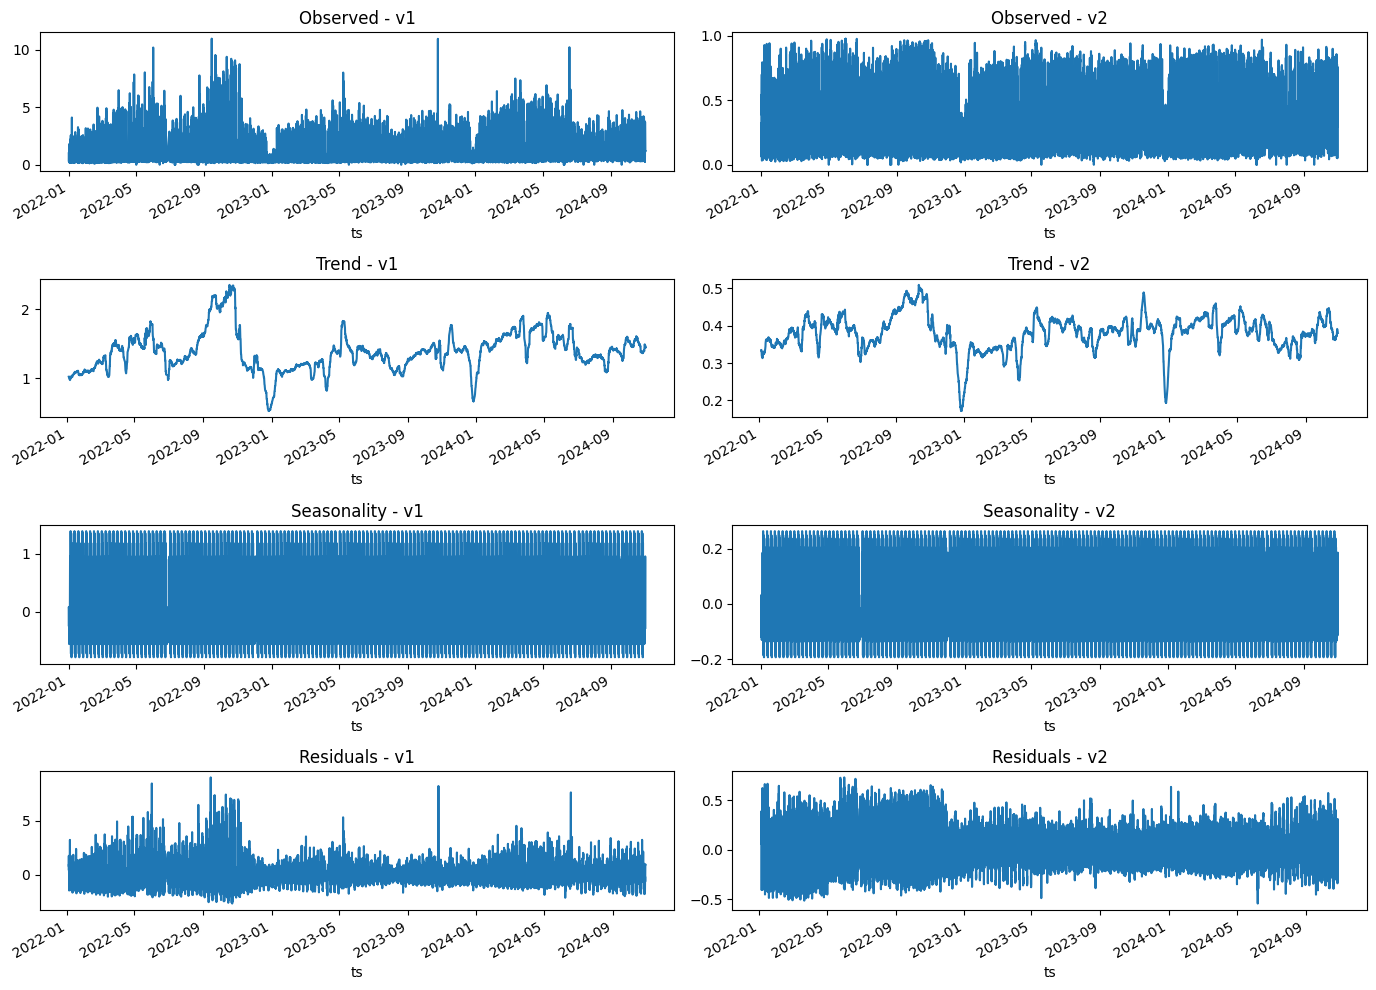

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose v1 and v2
result_v1 = seasonal_decompose(df['v1'], model='additive', period=24*7)
result_v2 = seasonal_decompose(df['v2'], model='additive', period=24*7)

# Plot decomposition
fig, axes = plt.subplots(4, 2, figsize=(14, 10))

# v1 decomposition
result_v1.observed.plot(ax=axes[0, 0], title="Observed - v1")
result_v1.trend.plot(ax=axes[1, 0], title="Trend - v1")
result_v1.seasonal.plot(ax=axes[2, 0], title="Seasonality - v1")
result_v1.resid.plot(ax=axes[3, 0], title="Residuals - v1")

# v2 decomposition
result_v2.observed.plot(ax=axes[0, 1], title="Observed - v2")
result_v2.trend.plot(ax=axes[1, 1], title="Trend - v2")
result_v2.seasonal.plot(ax=axes[2, 1], title="Seasonality - v2")
result_v2.resid.plot(ax=axes[3, 1], title="Residuals - v2")

plt.tight_layout()
plt.show()

## model wrappers 

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
import pandas as pd

# ARIMAX wrapper (for univariate forecasting)
class ARIMAXRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1,0,1), trend='n'):
        self.order = order
        self.trend = trend
        self.model_fit_ = None

    def fit(self, X, y):
        # X: exogenous features, y: target series (pd.Series)
        self.model_ = ARIMA(y, exog=X, order=self.order, trend=self.trend)
        self.model_fit_ = self.model_.fit()
        return self

    def predict(self, X):
        # Predict the next len(X) steps using exogenous features X
        steps = len(X)
        forecast = self.model_fit_.forecast(steps=steps, exog=X)
        return forecast

# VARMAX wrapper (for multivariate forecasting)
class VARMAXRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1,0), trend='n'):
        self.order = order
        self.trend = trend
        self.model_fit_ = None

    def fit(self, X, y):
        # Here, y is a DataFrame (with, e.g., v1 and v2), and X are exogenous features.
        self.model_ = VARMAX(y, exog=X, order=self.order, trend=self.trend)
        self.model_fit_ = self.model_.fit(disp=False)
        return self

    def predict(self, X):
        steps = len(X)
        forecast = self.model_fit_.forecast(steps=steps, exog=X)
        return forecast

## definign exogenous features 

In [38]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# 1. Make sure your exogenous features are strictly numeric
exog_features = df_work[[
    # 'year','month','day','hour','dayofweek',
    # 'is_eu_holiday','is_us_holiday',
    # 'v1_roll24_std','v2_roll24_std','v1_roll24_mean','v2_roll24_mean',
    # 'v1_from_v2_lag1','v2_from_v1_lag1','v1_lag1','v2_lag1',
    # 'trend','trend_sq'
    
    'year','month','day','hour',
    'dayofweek', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 
    'is_eu_holiday','is_us_holiday',
    'v1_lag24', 'v2_lag24', 
    'v1_roll24_std','v2_roll24_std','v1_roll24_mean','v2_roll24_mean',
    'v1_from_v2_lag1','v2_from_v1_lag1','v1_lag1','v2_lag1',
    'trend','trend_sq'
]].copy()

# Convert booleans to int if needed
exog_features['is_eu_holiday'] = exog_features['is_eu_holiday'].astype(int)
exog_features['is_us_holiday'] = exog_features['is_us_holiday'].astype(int)

# 2. Drop rows with any NaN values (to ensure alignment between exog and target)
mask = exog_features.notnull().all(axis=1)
exog_features = exog_features[mask]
series_clean = df_work.loc[mask, 'v1']
series_clean_v2 = df_work.loc[mask, 'v2']

# # 3. Remove constant columns (if any)
# for col in exog_features.columns:
#     if exog_features[col].nunique() <= 1:
#         print(f"Removing constant column: {col}")
#         exog_features.drop(columns=[col], inplace=True)

# 4. Ensure all columns are numeric
exog_features = exog_features.apply(pd.to_numeric, errors='coerce')


## arimax model - v1 and v2 with rolling window cv 

In [18]:
arimax_model = ARIMAXRegressor(order=(1,0,1), trend='n')

print('fitting model on v1')
# Then, using your ARIMAX pipeline and preprocessed exogenous features:
cv_results_prop, avg_metrics_prop = cross_validate_model_rolling_proportions(
    model=arimax_model,  # your ARIMAX pipeline
    X_exog=exog_features,      # preprocessed exogenous features
    y=series_clean,            # your target series (v1)
    train_frac=train_frac,
    test_frac=test_frac,
    n_folds=n_folds
)


print('fitting model on v2')
# Then, using your ARIMAX pipeline and preprocessed exogenous features:
cv_results_prop, avg_metrics_prop = cross_validate_model_rolling_proportions(
    model=arimax_model,  # your ARIMAX pipeline
    X_exog=exog_features,      # preprocessed exogenous features
    y=series_clean_v2,            # your target series (v1)
    train_frac=train_frac,
    test_frac=test_frac,
    n_folds=n_folds
)

fitting model on v1
Fold 0: RMSE=0.3610, R²=0.8612
Fold 1: RMSE=0.4011, R²=0.8707
Fold 2: RMSE=0.4202, R²=0.8805
Fold 3: RMSE=0.4481, R²=0.8732
Fold 4: RMSE=0.4351, R²=0.8706

Average Metrics (Rolling Proportions):
rmse    0.413125
r2      0.871230
dtype: float64
fitting model on v2
Fold 0: RMSE=0.0835, R²=0.8490
Fold 1: RMSE=0.0838, R²=0.8617
Fold 2: RMSE=0.0843, R²=0.8676
Fold 3: RMSE=0.0852, R²=0.8657
Fold 4: RMSE=0.0839, R²=0.8630

Average Metrics (Rolling Proportions):
rmse    0.084159
r2      0.861402
dtype: float64


A common reason for this discrepancy is that v2 likely operates on a different scale or has lower variability than v1. In your case, even though the R² values (which are relative measures) are similar, the absolute errors (RMSE) are much lower for v2. This can happen if v2’s values are smaller or less volatile compared to v1.

For example, if v1 ranges in the units of tens or hundreds while v2 is measured in fractions or single digits, even proportionally similar errors (in relative terms) will result in a lower RMSE for v2.

Other potential factors include:
	•	Different Noise Levels: v2 might inherently be less noisy or more predictable.
	•	Data Distribution: The variance of v2 is lower, so the same percentage error translates to a smaller absolute error.

In summary, the lower RMSE for v2 likely reflects its lower scale or variance, even though both models have similar relative performance as indicated by R².

## this works - var model - rmse    0.739483 r2      0.2151

In [23]:
# Assume the following functions have already been defined:
# - rolling_window_split_proportions(n_samples, train_frac, test_frac, n_folds)
# - cross_validate_pipeline_rolling_proportions(pipeline, X_exog, y, train_frac, test_frac, n_folds)
# Also assume that exog_features is already defined and preprocessed.

# Define your endogenous DataFrame for the VAR model (v1 and v2)
df_endog = df_work[['v1', 'v2']].copy()
df_endog = df_work.loc[mask, ['v1', 'v2']]

# Define a VARMAX pipeline (using the VARMAXRegressor defined earlier)

varmax = VARMAXRegressor(order=(3,0), trend='n')

# Set your proportional splits: for example, 60% training, 20% testing, and 5 folds
# train_frac = 0.60
# test_frac  = 0.20
# n_folds    = 5

# Run cross-validation using the same function as before
cv_results_var, avg_metrics_var = cross_validate_model_rolling_proportions(
    model=varmax,
    X_exog=exog_features,      # same exogenous features as before
    y=df_endog,               # now the target is the DataFrame with v1 and v2
    train_frac=train_frac, # chnaged this so i dont get an out of bounds error 
    test_frac=test_frac,
    n_folds=5
)

# The function will print per-fold RMSE and R² for each variable (v1 and v2),
# and then output a summary DataFrame and average metrics.

Fold 0: {'v1_rmse': 0.5184733202002766, 'v1_r2': 0.7136777241766037, 'v2_rmse': 0.1129558424458501, 'v2_r2': 0.724014439889487}
Fold 1: {'v1_rmse': 0.5837757786138008, 'v1_r2': 0.721857377672544, 'v2_rmse': 0.11662240823339484, 'v2_r2': 0.7314684583363662}
Fold 2: {'v1_rmse': 0.6029736795571832, 'v1_r2': 0.7291363366404947, 'v2_rmse': 0.11812178745976462, 'v2_r2': 0.7305489290831427}
Fold 3: {'v1_rmse': 0.6485879545009495, 'v1_r2': 0.7257610195176246, 'v2_rmse': 0.12153878836140702, 'v2_r2': 0.7278073481173808}


KeyboardInterrupt: 

## xg boost 

In [19]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV

# # Define a parameter grid – adjust ranges based on your knowledge of the data.
# param_grid = {
#     'n_estimators': [50, 100],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [3, 7],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Create the XGBRegressor
# xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# # Create the grid search object (using a time series aware CV if needed)
# # For time series, you might want to use TimeSeriesSplit instead of KFold.
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)

# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='r2',     # or use neg_mean_squared_error
#     cv=tscv,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit on the training data (exog_features_processed and series_clean)
# grid_search.fit(exog_features, series_clean)

# print("Best Parameters:", grid_search.best_params_)
# print("Best CV Score:", grid_search.best_score_)

In [41]:
from xgboost import XGBRegressor

# Create an XGBoost regressor with typical settings for regression.
# xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, 
#                          learning_rate=0.1, random_state=42)

xgb_model = XGBRegressor(
    n_estimators=500,  # Increase trees to capture more patterns
    learning_rate=0.01,  # Reduce step size for better fine-tuning
    max_depth=8,  # Increase depth to allow better feature interactions
    subsample=0.8,  # Use 80% of data per tree to reduce overfitting
    colsample_bytree=0.8,  # Use 80% of features per tree
    gamma=1,  # Reduce overfitting by adding loss regularization
    objective="reg:squarederror",
    random_state=42
)

# Now, use the universal CV function we defined earlier.

y_train_log_v1 = np.log1p(series_clean)
y_train_log_v2 = np.log1p(series_clean_v2)

print("v1")
# This function expects a model object that implements fit(X, y) and predict(X).
cv_results_xgb, avg_metrics_xgb = cross_validate_model_rolling_proportions(
    model=xgb_model,
    X_exog=exog_features,  # your preprocessed exogenous features DataFrame
    y=y_train_log_v1,                  # your target series (e.g., v1) as a pd.Series
    train_frac=train_frac,                 # e.g., 60% of samples for training per fold
    test_frac=test_frac,                  # e.g., 20% for testing per fold
    n_folds=n_folds                        # desired number of folds
)


print("v2")
# This function expects a model object that implements fit(X, y) and predict(X).
cv_results_xgb, avg_metrics_xgb = cross_validate_model_rolling_proportions(
    model=xgb_model,
    X_exog=exog_features,  # your preprocessed exogenous features DataFrame
    y=y_train_log_v2,                  # your target series (e.g., v1) as a pd.Series
    train_frac=train_frac,                 # e.g., 60% of samples for training per fold
    test_frac=test_frac,                  # e.g., 20% for testing per fold
    n_folds=n_folds                        # desired number of folds
)


v1
Fold 0: RMSE=0.1079, R²=0.9163
Fold 1: RMSE=0.1077, R²=0.9277
Fold 2: RMSE=0.1102, R²=0.9315
Fold 3: RMSE=0.1131, R²=0.9300
Fold 4: RMSE=0.1117, R²=0.9259

Average Metrics (Rolling Proportions):
rmse    0.110136
r2      0.926273
dtype: float64
v2
Fold 0: RMSE=0.0553, R²=0.8710
Fold 1: RMSE=0.0550, R²=0.8815
Fold 2: RMSE=0.0556, R²=0.8840
Fold 3: RMSE=0.0563, R²=0.8816
Fold 4: RMSE=0.0568, R²=0.8733

Average Metrics (Rolling Proportions):
rmse    0.055790
r2      0.878288
dtype: float64


## diagnostics 

In [42]:
mask_holdout = df_holdout.notnull().all(axis=1)
holdout_y_v1 = df_holdout.loc[mask_holdout, 'v1']
holdout_y_v2 = df_holdout.loc[mask_holdout, 'v2']

# print("holdout - v1")
# # This function expects a model object that implements fit(X, y) and predict(X).
# cv_results_xgb, avg_metrics_xgb = cross_validate_model_rolling_proportions(
#     model=xgb_model,
#     X_exog=exog_features,  # your preprocessed exogenous features DataFrame
#     y=holdout_y_v1,                  # your target series (e.g., v1) as a pd.Series
#     train_frac=train_frac,                 # e.g., 60% of samples for training per fold
#     test_frac=test_frac,                  # e.g., 20% for testing per fold
#     n_folds=n_folds                        # desired number of folds
# )


# print("holdout - v2")
# # This function expects a model object that implements fit(X, y) and predict(X).
# cv_results_xgb, avg_metrics_xgb = cross_validate_model_rolling_proportions(
#     model=xgb_model,
#     X_exog=exog_features,  # your preprocessed exogenous features DataFrame
#     y=holdout_y_v2,                  # your target series (e.g., v1) as a pd.Series
#     train_frac=train_frac,                 # e.g., 60% of samples for training per fold
#     test_frac=test_frac,                  # e.g., 20% for testing per fold
#     n_folds=n_folds                        # desired number of folds
# )

In [64]:
X_holdout = df_holdout.copy().drop(columns=['v2'])
y_actual_holdout = df_holdout['v2'].copy()

In [65]:

features = df_holdout[[
    'year','month','day','hour',
    'dayofweek', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 
    'is_eu_holiday','is_us_holiday',
    'v1_lag24', 'v2_lag24', 
    'v1_roll24_std','v2_roll24_std','v1_roll24_mean','v2_roll24_mean',
    'v1_from_v2_lag1','v2_from_v1_lag1','v1_lag1','v2_lag1',
    'trend','trend_sq'
]].copy()

y_holdout_pred = xgb_model.predict(features)
y_holdout_pred = np.expm1(y_holdout_pred)

In [66]:

std_dev = np.std(y_holdout_pred)  # Adjust this based on model residuals if available
lower_bound = y_holdout_pred - 1.96 * std_dev  # Approx. 95% confidence interval
upper_bound = y_holdout_pred + 1.96 * std_dev

In [67]:

df_plot = pd.DataFrame({
    'date': df_holdout.index,  # Assuming the index is a datetime
    'p': y_actual_holdout,  # Actual Y values
    'p_pred': y_holdout_pred,  # Predicted Y values
    'lower p': lower_bound,
    'upper p': upper_bound
})

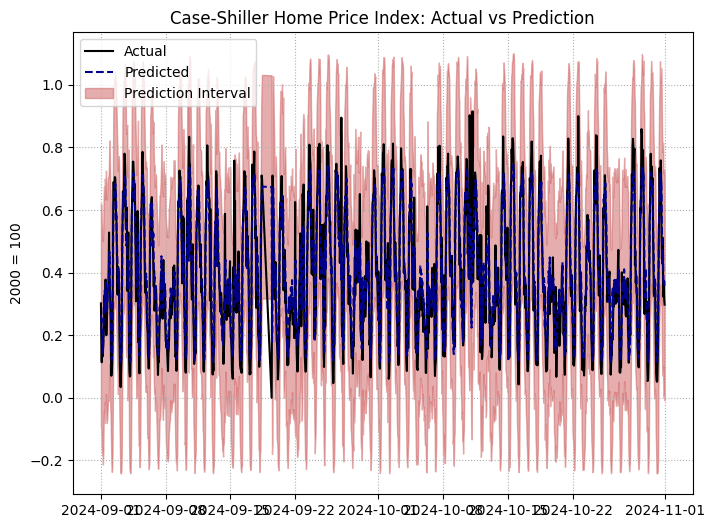

In [68]:

plt.figure(figsize=(8,6))
plt.plot(df_plot.date, df_plot.p, color='k', label='Actual')
plt.plot(df_plot.date, df_plot.p_pred, color='darkblue', linestyle='--', label='Predicted')
plt.fill_between(df_plot.date, df_plot['lower p'], df_plot['upper p'], color='indianred', alpha=0.5, label='Prediction Interval')
plt.legend(loc='upper left')
plt.ylabel('2000 = 100')
plt.grid(True, linestyle=':')
#plt.yticks(range(220, 340, 10))
plt.title('Case-Shiller Home Price Index: Actual vs Prediction')

plt.show()

In [69]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate errors
errors = y_actual_holdout - y_holdout_pred
mae = mean_absolute_error(y_actual_holdout, y_holdout_pred)
mse = mean_squared_error(y_actual_holdout, y_holdout_pred)
rmse = np.sqrt(mse)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.0619
Mean Squared Error (MSE): 0.0074
Root Mean Squared Error (RMSE): 0.0861


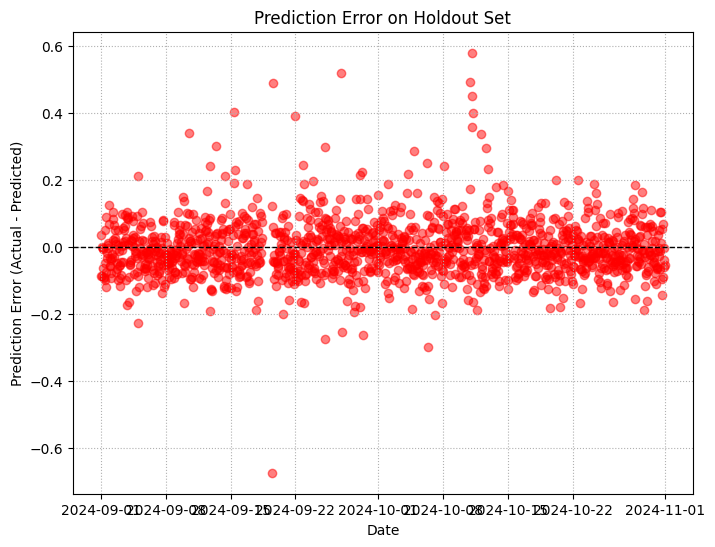

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_plot.date, errors, color='red', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Zero error line
plt.xlabel("Date")
plt.ylabel("Prediction Error (Actual - Predicted)")
plt.title("Prediction Error on Holdout Set")
plt.grid(True, linestyle=':')

plt.show()

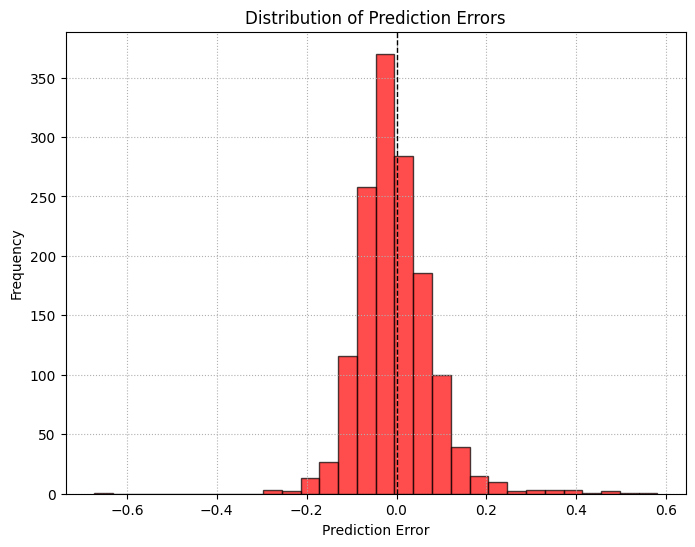

In [71]:
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, color='red', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.grid(True, linestyle=':')

plt.show()

In [72]:
mean_error = np.mean(errors)
print(f"Mean Prediction Error: {mean_error:.4f}")

Mean Prediction Error: -0.0044


# daily fan chart 

In [73]:

actuals_daily = df_holdout[['v2']].resample('D').mean()

preds_df = pd.DataFrame(
    {'predictions': y_holdout_pred},
    index=df_holdout.index  # must be a DatetimeIndex
)

preds_daily = preds_df.resample('D').mean()

In [74]:
df_plot = pd.concat([actuals_daily, preds_daily], axis=1)
df_plot.columns = ['actual', 'predicted']  # rename for clarity

print(df_plot.head())

              actual  predicted
ts                             
2024-09-01  0.275055   0.297225
2024-09-02  0.427545   0.437735
2024-09-03  0.444247   0.439862
2024-09-04  0.440487   0.448853
2024-09-05  0.423107   0.452984


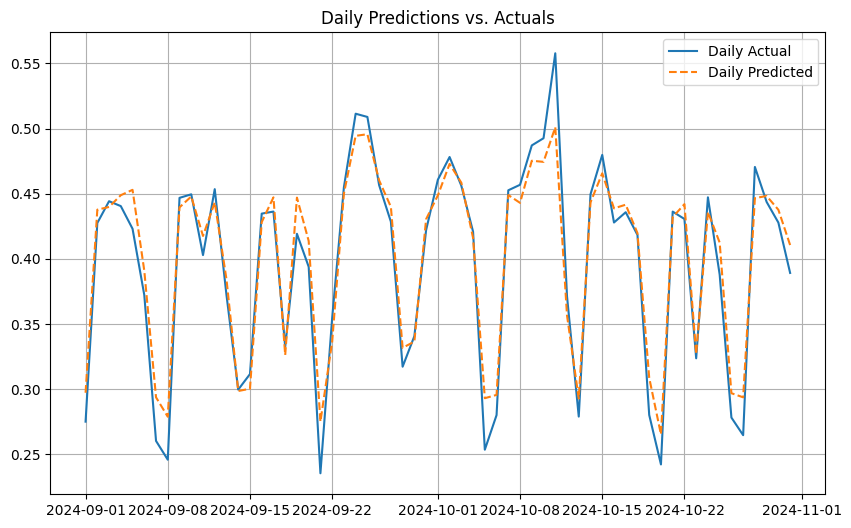

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['actual'], label='Daily Actual')
plt.plot(df_plot.index, df_plot['predicted'], label='Daily Predicted', linestyle='--')
plt.legend()
plt.title("Daily Predictions vs. Actuals")
plt.grid(True)
plt.show()

In [60]:
plt.figure(figsize=(10,6))
plt.plot(df_plot.index, df_plot['predicted'], label='Predicted')
plt.fill_between(
    df_plot.index,
    df_plot['predicted_lower'],  # daily lower bound
    df_plot['predicted_upper'],  # daily upper bound
    alpha=0.2, label='Prediction Interval'
)
plt.plot(df_plot.index, df_plot['actual'], label='Actual')
plt.legend()
plt.title("Daily Prediction with Fan Chart")
plt.grid(True)
plt.show()

KeyError: 'predicted_lower'

 __

# umm 

In [76]:
df_holdout

,v1,v2,year,quarter,month,day,hour,dayofweek,weekend,hour_sin,...,v1_lag24,v2_lag24,v1_from_v2_lag1,v2_from_v1_lag1,v1_roll24_mean,v2_roll24_mean,v1_roll24_std,v2_roll24_std,trend,trend_sq
ts,,,,,,,,,,,,,,,,,,,,,
2024-09-01 00:00:00,0.998636,0.301608,2024,3,9,1,0,7,1,0.000000,...,0.752459,0.232851,0.343887,1.000231,0.967286,0.268372,0.318845,0.099695,23152,536015104
2024-09-01 01:00:00,0.682140,0.172168,2024,3,9,1,1,7,1,0.258819,...,0.648323,0.210400,0.301608,0.998636,0.968695,0.266779,0.317446,0.100959,23153,536061409
2024-09-01 02:00:00,0.637260,0.113355,2024,3,9,1,2,7,1,0.500000,...,0.652689,0.151902,0.172168,0.682140,0.968052,0.265173,0.318129,0.103149,23154,536107716
2024-09-01 03:00:00,0.683333,0.174769,2024,3,9,1,3,7,1,0.707107,...,0.418387,0.110993,0.113355,0.637260,0.979091,0.267830,0.302435,0.099770,23155,536154025
2024-09-01 04:00:00,0.507203,0.131376,2024,3,9,1,4,7,1,0.866025,...,0.369277,0.069172,0.174769,0.683333,0.984838,0.270422,0.291455,0.095083,23156,536200336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,1.152634,0.368448,2024,4,10,31,19,4,0,-0.965926,...,1.111286,0.333613,0.511426,1.807951,1.488908,0.391743,0.978741,0.228669,24587,604520569
2024-10-31 20:00:00,1.228804,0.322425,2024,4,10,31,20,4,0,-0.866025,...,1.190002,0.324819,0.368448,1.152634,1.490524,0.391643,0.978258,0.228700,24588,604569744
2024-10-31 21:00:00,1.281062,0.361132,2024,4,10,31,21,4,0,-0.707107,...,1.295105,0.374742,0.322425,1.228804,1.489939,0.391076,0.978384,0.228761,24589,604618921


In [77]:
from scipy.stats import ks_2samp

# KS test for v1
stat, p_value = ks_2samp(df_work['v1'], df_holdout['v1'])
print("KS test for v1: Statistic =", stat, "p-value =", p_value)

stat, p_value = ks_2samp(df_work['v2'], df_holdout['v2'])
print("KS test for v2: Statistic =", stat, "p-value =", p_value)

KS test for v1: Statistic = 0.1283268064194118 p-value = 6.301381188720054e-20
KS test for v2: Statistic = 0.06778728019657526 p-value = 7.320963676985235e-06


The KS test results are telling you that there is a statistically significant difference in the distributions between your work set and holdout set for both v1 and v2:
	•	For v1:
	•	Statistic: 0.1283 – This is the maximum difference between the two cumulative distribution functions.
	•	p-value: ~6.3e-20 – This extremely low p-value indicates that the probability of observing such a difference by chance is virtually zero.
In short, the distribution of v1 in the work set is significantly different from that in the holdout set.
	•	For v2:
	•	Statistic: 0.0678 – The maximum difference in the cumulative distributions is smaller compared to v1.
	•	p-value: ~7.32e-06 – Still very low, which means that the difference is statistically significant even if it is less pronounced than for v1.

In summary, both tests strongly suggest that there is a distribution shift between your work set and holdout set for both v1 and v2. This could be one of the reasons why your model’s performance on the holdout is different (often lower) than on the training data.


retrain model on al data before making forecasts 